In this notebook, we take a look at response-time-related analyses

# Table of Contents
1. [Preparing the data and plots](#preparing)
2. [Response time](#RT)
    * [Correct vs error trials](#RT_correct_error)
    * [CoM vs non-CoM trials](#RT_CoM)
3. [Negative response times](#negative)

<a name="preparing"></a>
# Preparing data and plots
First, we set up visuals and read the data.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import random
import data_reader
import os

model_output_csv_path = '../output/csv/'

with open('figure_path.txt') as f:
    figure_path = f.read()

with open('data_path.txt') as f:
    data_path = f.read()

dr = data_reader.DataReader()
choices, dynamics, stim_viewing = dr.get_data(path=os.path.join(data_path, 'processed'), rename_vars=True, stim_viewing=True)

# here we need to highlight the data by subj_id, and this is currently not possible in seaborn with multi-index dataframes
choices = choices.reset_index()

Let's define a few functions used further to plot initiation times as a function of coherence split by choice and type

In [3]:
import matplotlib.lines as mlines

def plot_var_vs_coherence(choices, var, estimator=np.mean): 
    palette_subj = 'magma_r'
    scale = 1
    subj_order = sorted(choices.subj_id.unique())
    
    plt.figure()
    
    ax = sns.pointplot(data=choices[(choices.is_correct) & (choices.coherence>0)], 
                       x='coherence', y=var, hue='subj_id', 
                       palette=palette_subj, scale=scale, errwidth=0.5, alpha=0.7,
                       join=False, dodge=True, capsize=.2, hue_order=subj_order,
                       estimator=estimator)
    
    ax = sns.pointplot(data=choices[(~choices.is_correct) & (choices.coherence>0)], 
                       x='coherence', y=var, hue='subj_id', 
                       palette=palette_subj, linestyles=np.repeat(['--'], len(choices.subj_id.unique())), 
                       markers=np.repeat(['x'], len(choices.subj_id.unique())), scale=scale,
                       errwidth=0.5, dodge=True, capsize=.2, join=False, 
                       hue_order=subj_order, estimator=estimator, ax=ax)

    ax = sns.pointplot(data=choices[(choices.coherence>0) & (~choices.is_correct)], 
                       x='coherence', y=var, linestyles=['--'], color='grey',
                       markers=['x'], scale=scale, errwidth=0.5, estimator=estimator, ax=ax)
    
    ax = sns.pointplot(data=choices[(choices.coherence>0) & (choices.is_correct)],
                       x='coherence', y=var, linestyles=['-'], color='grey', 
                       scale=scale, errwidth=0.5, estimator=estimator, ax=ax)


#     ax.set_ylim([0, 1.2])      
    ax.set_xlabel('Coherence')
    ax.set_ylabel(var)
    
    ax.legend_.remove()
    correct_line = mlines.Line2D([], [], color='grey', marker='o', lw=3.0, label='Correct')
    error_line = mlines.Line2D([], [], color='grey', marker='x', ls='--', lw=3.0, label='Error')
    plt.legend(handles=[correct_line, error_line], frameon=False)
    
    sns.despine(ax=ax, trim=True, offset=5)
    
    plt.tight_layout()
#     plt.savefig(('figures/%s_vs_coherence_ind_%s' % 
#                  (var.replace('(', '').replace(')', ''), exp)).replace(' ', '_'), bbox_inches='tight')
    
def plot_var_grid_individual(choices, var, col, hue, hue_order, col_order, markers, estimator=np.mean):
    ax = sns.catplot(kind='point', data=choices[choices.coherence>0], x='coherence', y=var, 
                        col=col, row='subj_id', markers = markers, hue=hue, hue_order=hue_order,
                        capsize=.2, errwidth=0.5, estimator=estimator)
    ax.set_ylabels('Response time (z)')
    
    plt.subplots_adjust(top=0.9)    
    
#     plt.savefig(('../../figures_output/%s_vs_coherence_grid_by_%s_ind' % (var, hue)).replace(' ', '_'))

def plot_var_grid(choices, var, col, hue, hue_order, col_order, markers, estimator=np.mean, title=True, xlabels=True):
    fig = sns.catplot(kind='point', data=choices[choices.coherence>0], x='coherence', y=var, col=col, 
                         linestyles=['-','--'], markers = markers, hue=hue, hue_order=hue_order, col_order=col_order,
                         capsize=.2, errwidth=0.5, ylim=(-1, 1), estimator=estimator, legend=False)
    fig.set_xticklabels(rotation=30)
    fig.set(ylim=(-2.5, 2.5))
    fig.set_titles('')
    plt.subplots_adjust(top=0.8)
    fig.despine(trim=True, offset=10)
    if not xlabels:
        fig.set_xlabels('')
    
    if title:        
        fig.set_titles('{col_name}')
        
    plt.legend(loc='lower left', frameon=False)
#     plt.savefig(('figures/%s_vs_coherence_grid_by_%s_%s' % 
#                  (var.replace('(', '').replace(')', ''), hue, exp)).replace(' ', '_'), bbox_inches='tight')

<a name="RT"></a>
# Response time

First, we plot RT distributions for CoM and non-CoM trials disregarding coherence. Note that RT can be negative, as premature responses during stimulus presentations are factored in during pre-processing.

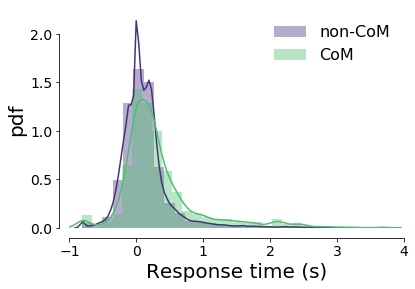

In [5]:
sns.set_palette('viridis')
ax = sns.distplot(choices[~choices.is_com].RT, bins=30, label='non-CoM', color='C0')
sns.distplot(choices[choices.is_com].RT, bins=30, ax=ax, label='CoM', color='C4')
ax.set_ylabel('pdf')
ax.set_xlim(-1, 4)
ax.set_xlabel('Response time (s)')
sns.despine(ax=ax, trim=True, offset=10)

plt.legend(frameon=False)
plt.savefig(os.path.join(figure_path, 'RT.png') , bbox_inches='tight')

Now, let's look at RTs for each coherence level

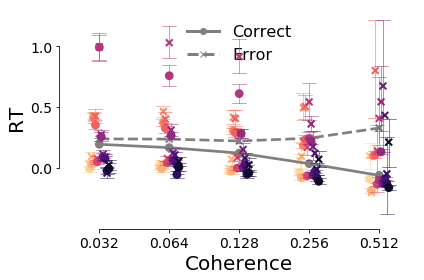

In [6]:
plot_var_vs_coherence(choices, var='RT')

Pretty much what we expect: RT decreases with coherence for correct trials, and remains more-less constant or even increases for error trials __(the '<-pattern')__.

Z-scored RT highlights the same pattern:

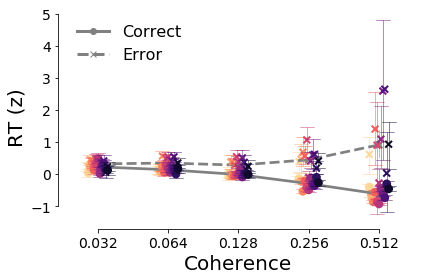

In [7]:
plot_var_vs_coherence(choices, var='RT (z)')

These plotting functions are used for the mouse and eye IT data analyses below

## RT in correct vs error trials

Taking into account individual differences in RT, it is useful to account for those when looking into RTs for CoM and non-CoM trials. Here we have to look at z-scored response times

After we accounted for magnitude of within-individual RT, we can see how relative magnitude of RT changes with coherence in non-CoM and CoM trials:

In [12]:
sns.set_palette('tab10')

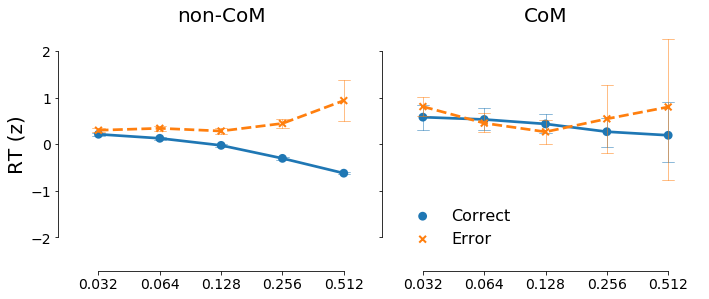

In [13]:
plot_var_grid(choices, var='RT (z)', col='type', hue='choice', 
              hue_order=['Correct', 'Error'],  col_order=['non-CoM', 'CoM'], markers=['o', 'x'], xlabels=False)

Surprisingly, in CoM trials participants exhibit indistinguishable RTs in correct and error trials

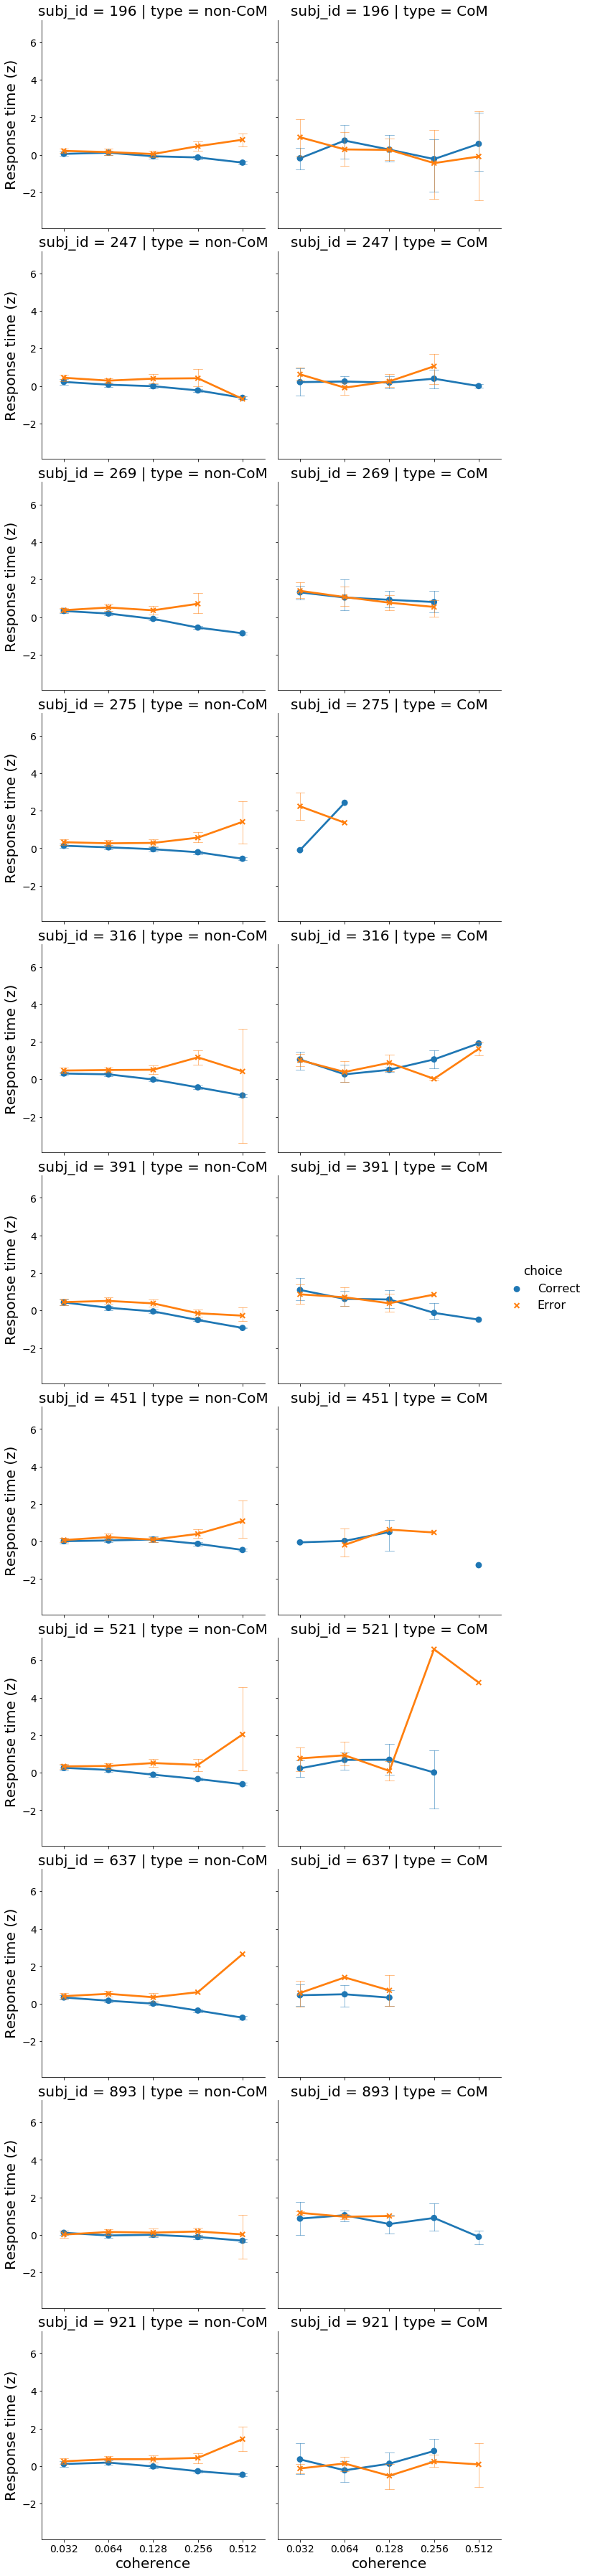

In [10]:
plot_var_grid_individual(choices, var='RT (z)', col='type', hue='choice', 
                        hue_order=['Correct', 'Error'], col_order=['non-CoM', 'CoM'], markers=['o', 'x'])

## RT in CoM vs non-CoM trials

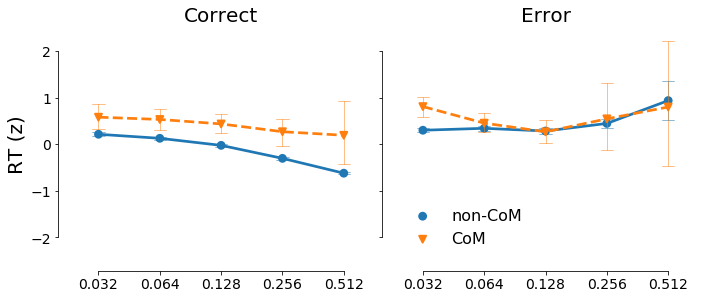

In [14]:
plot_var_grid(choices, var='RT (z)', col='choice', hue='type', 
              hue_order=['non-CoM', 'CoM'], col_order=['Correct', 'Error'], markers=['o', 'v'], xlabels=False)

Correct RTs are reliably longer than those in error trials

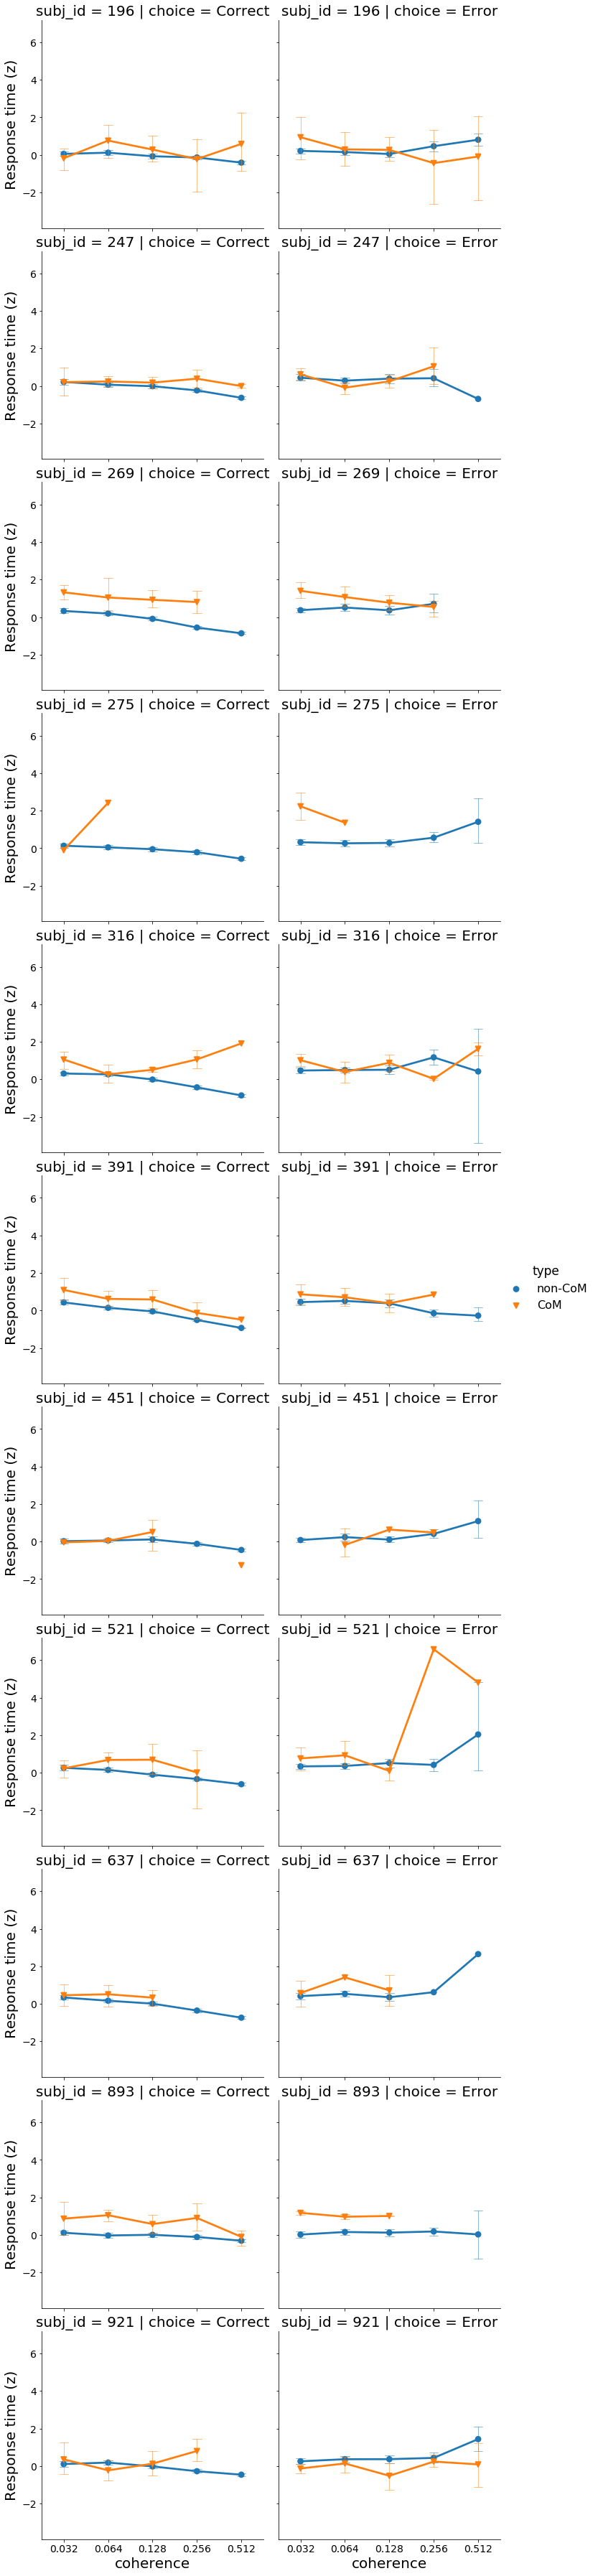

In [15]:
plot_var_grid_individual(choices, var='RT (z)', col='choice', hue='type', 
              hue_order=['non-CoM', 'CoM'], col_order=['Correct', 'Error'], markers=['o', 'v'])

<a name="negative"></a>
# Negative initiation times

Premature responses were observed in 30% of the trials

In [9]:
def print_neg_RT_proportion(choices):
    print('N: %i' % (len(choices[(choices['RT']<0)])))    
    print('at 0.256 and 0.512 coherences: %.3f' % 
          (len(choices[(choices['RT']<0) & (choices.coherence>0.2)])/(len(choices[(choices['RT']<0)]))))
    print('rate: %.3f' % (len(choices[(choices['RT']<0)])/len(choices)))

print_neg_RT_proportion(choices)

N: 7951
at 0.256 and 0.512 coherences: 0.518
rate: 0.303


However, just 18% of CoM trials had premature responses

In [4]:
print_neg_RT_proportion(choices[choices.is_com])

N: 139
at 0.256 and 0.512 coherences: 0.137
rate: 0.179


In [10]:
print_neg_RT_proportion(choices[~choices.is_com])

N: 7812
at 0.256 and 0.512 coherences: 0.525
rate: 0.306


The number of negative RTs increases with coherence for non-CoM trials

In [47]:
def plot_n_neg_rt(choices):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    n_neg_rt = choices.groupby(by=['coherence', 'type']).apply(lambda c: (len(c[c['RT']<0]))).rename('neg_RT').reset_index()
    sns.pointplot(data=n_neg_rt, x='coherence', y='neg_RT', ax=ax, palette=['grey', 'black'], hue='type')
    ax.set_xlabel('coherence')
    ax.get_legend().set_title('')
    sns.despine(ax=ax, trim=True, offset=10)
    return ax

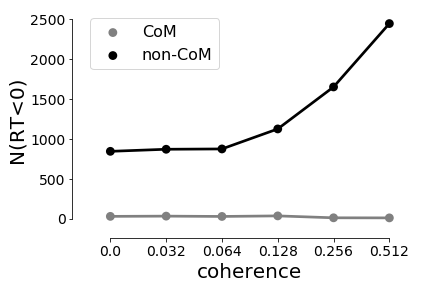

In [62]:
ax = plot_n_neg_rt(choices)
ax.set_ylabel('N(RT<0)')
plt.savefig(os.path.join(figure_path, 'n_neg_rt.png') , bbox_inches='tight')

Let's see how the proportion of premature response changes with coherence for CoM and non-CoM trials

In [45]:
def get_p_neg_rt_ci(c, n_threshold=5):
    p = c.groupby(by=['coherence', 'type']).apply(lambda c: (len(c[c['RT']<0]))/len(c))

    ci = pd.DataFrame(p, columns=['p_neg_rt'], 
                        index=pd.MultiIndex.from_product([np.sort(c.coherence.unique()), 
                                                          np.sort(c.type.unique())], 
                                                         names=['coherence', 'type']))
    n = [len(c[(c.coherence==coherence) & (c.type==t)]) 
                      for coherence in np.sort(c.coherence.unique()) 
                      for t in np.sort(c.type.unique())]

    ci['ci_l'] = ci['p_neg_rt'] - np.sqrt(p*(1-p)/n)
    ci['ci_r'] = ci['p_neg_rt'] + np.sqrt(p*(1-p)/n)

    return ci.reset_index()

In [54]:
def plot_p_neg_rt(choices):
    fig, ax = plt.subplots()
    ci = get_p_neg_rt_ci(choices)
    sns.pointplot(data=ci, x='coherence', y='p_neg_rt', hue='type', styles=['o', 'v'], 
                      scale=1, join=True, palette=['grey', 'black'], linestyles=['-', '-'], ax=ax)
    ax.vlines(x=range(0,6), ymin=ci[ci.type=='non-CoM'].ci_l, ymax=ci[ci.type=='non-CoM'].ci_r, 
                 color='black', zorder=10)    
    ax.vlines(x=range(0,6), ymin=ci[ci.type=='CoM'].ci_l, ymax=ci[ci.type=='CoM'].ci_r, 
                 color='grey', zorder=10)
    
    ax.set_xlabel('coherence')
    ax.set_ylabel('p(RT<0)')
    ax.get_legend().set_title('')
    sns.despine(ax=ax, trim=True, offset=10)
    return ax

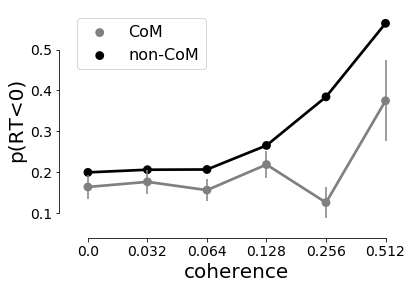

In [61]:
plot_p_neg_rt(choices)
plt.savefig(os.path.join(figure_path, 'p_neg_rt.png') , bbox_inches='tight')

# Time of CoM

`midline_d_t` is the time of CoM relative to stimulus offset

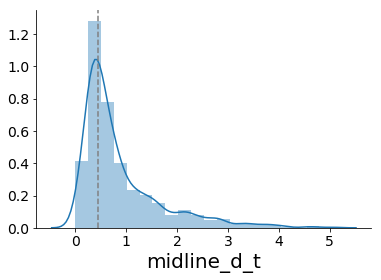

In [56]:
ax = sns.distplot(choices[choices.is_com].midline_d_t, bins=20)
ax.axvline(0.45, color='grey', ls='--')

Majority (63%) of CoMs are generated later than 450 ms after stimulus offset

In [2]:
print(len(choices[choices.is_com & (choices.midline_d_t>0.45)])/len(choices[choices.is_com]))

0.6283870967741936


And 83% happen after 300 ms (the CoM deadline used by Resulaj et al.)

In [3]:
print(len(choices[choices.is_com & (choices.midline_d_t>0.3)])/len(choices[choices.is_com]))

0.8348387096774194


Only look at the trials with non-negative RT

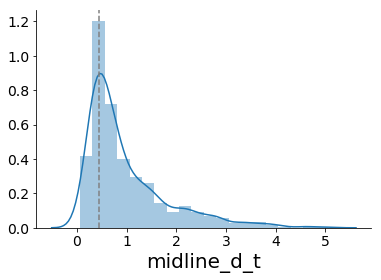

In [118]:
ax = sns.distplot(choices[(choices.is_com) & (choices['RT']>=0)].midline_d_t, bins=20) 
ax.axvline(0.45, color='grey', ls='--')

In these trials, 72% of CoM happened later than 450ms after the stimulus offset

In [122]:
print(len(choices[(choices.is_com) & (choices['RT']>=0) & (choices.com_type=='late')]) / 
      len(choices[(choices.is_com) & (choices['RT']>=0)]))

0.7154088050314465


Plot all "early" changes-of-mind (could potentially be affected by late-coming evidence)

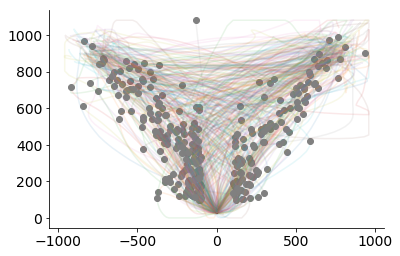

In [119]:
choices_ind = choices.set_index(dynamics.index.names)
for name, traj in dynamics.loc[choices_ind[choices_ind.is_com & 
                                           (choices_ind.com_type=='early')].index].groupby(dynamics.index.names):
    plt.plot(traj.mouse_x, traj.mouse_y, alpha=0.1)
    com_idx = int(choices_ind.loc[name].idx_midline_d)  
    plt.plot(traj.mouse_x[com_idx], traj.mouse_y[com_idx], color='grey', marker='o')

Plot all "late" changes-of-mind (no direct effect of late-coming evidence)

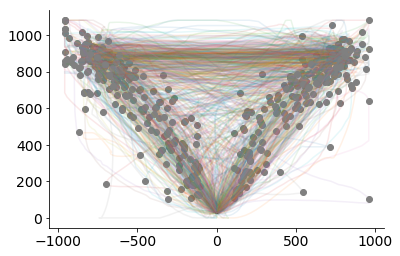

In [123]:
for name, traj in dynamics.loc[choices_ind[choices_ind.is_com & 
                                           (choices_ind.com_type=='late')].index].groupby(dynamics.index.names):
    plt.plot(traj.mouse_x, traj.mouse_y, alpha=0.1)
    com_idx = int(choices_ind.loc[name].idx_midline_d)  
    plt.plot(traj.mouse_x[com_idx], traj.mouse_y[com_idx], color='grey', marker='o')